# More extended PyDSTool for computational Neuroscience

This Notebook is inspired by http://www2.gsu.edu/~matrhc/FrontPage.html and by the examples which can be found at https://github.com/robclewley/pydstool/tree/master/examples

For the Hodgkin-Huxley model the main part of the code is taken from the exampels of Robert Clewley as specified in the following code.

## Noisy Hodgkin-Huxley

In this part we will compute the Hodgkin-Huxley model. In the network, each neuron is described by a Hodgkin-Huxley model neuron, consisting of four coupled ordinary differential equation associated to the membrane potential V and the ioniccurrents flowing across the axonal membrane corresponding to the Na, K, and leakage currents. The gating variable for sodium are h and m and that for potassium is n. The equations are :
$$ Cm \frac{dV}{dt} = G_{Na} m^3 h (E_{Na}-V) + G_{K} n^4 (E_K - V) + G_m (V_{rest}-V) + I + I_{syn}  $$
$$  \frac{dx}{dt} = \alpha_{x}(V) (1-x) - \beta_{x}(V)x $$
where $x \in {n,h,m}$ and $C_m = 9 \pi \, \mu F$ is the membrane capacitance of the membrane. I is a constant current that sets the neuron excitability and $\sum I_{syn}$ accounts for the interaction with other neurons. The reversal potentials are $E_{Na} = 115 mV$, $E_K = -12 mV$, and $V_{rest}= 10.6 mV$. The conductances associated are $G_{Na}= 1080 \pi mS$, $G_K = 324 \pi mS$, and $G_m = 2.7 \pi mS$. In the Hodgkin-Huxley model the voltage dependant rate are :
$$ \alpha_{n}(V)= \frac{10 - V}{100(e^{(10-V)/10}-1)}$$
$$ \beta_{n}(V) = 0.125 e^{-V/80}$$
$$ \alpha_{m}(V) = \frac{25-V}{10(e^{(25-V)/10}-1)}$$
$$ \beta_{m}(V) = 4e^{-V/18}$$
$$ \alpha_{h}(V) = 0.07 e^{-V/20}$$
$$ \beta_{h}(V) = \frac{1}{(e^{(30-V)/10}+1)}$$
We have considered the resting potential of the model at $I=0$. Later we will not use this exact parameters but it will just be a renormalization of these equations. 

Because we are using Python3 we need to code a different program as in the tutorial, but the idea is the same. This leads to the following initialization : (It works better on python 2 right now)
It could be better to not use a Jupyter Notebook to work with this package but in order to show the results we will still be using it. 

In [2]:
"""A demonstration of a model for a single Hodgkin-Huxley membrane
potential for an oscillatory cortical neuron. (Includes demo of saving
a Model object). Uses direct FuncSpec specification with strings.
See ModelSpec_test.py for example of using the neuralcomp toolbox.

   Robert Clewley, June 2005.
   
Some modifications to adapt this code to this notebook : Kevin Berlemont , March, 2017
"""
from __future__ import print_function

from PyDSTool import *
from time import clock
from copy import copy

# ------------------------------------------------------------


def makeHHneuron(name, par_args, ic_args, evs=None, extra_terms='',
                 gentype='vode'):
    # extra_terms must not introduce new variables!
    vfn_str = '(Iapp'+extra_terms+'-ionic(v,m,h,n))/C'
    mfn_str = 'ma(v)*(1-m)-mb(v)*m'
    nfn_str = 'na(v)*(1-n)-nb(v)*n'
    hfn_str = 'ha(v)*(1-h)-hb(v)*h'
    aux_str = 'm*m*m*h'

    auxdict = {'ionic': (['vv', 'mm', 'hh', 'nn'],
            'gna*mm*mm*mm*hh*(vv-vna) + gk*nn*nn*nn*nn*(vv-vk) + gl*(vv-vl)'),
               'ma': (['v'], '0.32*(v+54)/(1-exp(-(v+54)/4))'),
               'mb': (['v'], '0.28*(v+27)/(exp((v+27)/5)-1)'),
               'ha': (['v'], '.128*exp(-(50+v)/18)'),
               'hb': (['v'], '4/(1+exp(-(v+27)/5))'),
               'na': (['v'], '.032*(v+52)/(1-exp(-(v+52)/5))'),
               'nb': (['v'], '.5*exp(-(57+v)/40)'),
               'ptest': (['p'], '1+p+ma(-50)+C'),
               'atest': (['q'], 'q+mb(-40)')}  # tests fn cross-calling

    DSargs = args()
    DSargs.varspecs = {'v': vfn_str, 'm': mfn_str,
                       'h': hfn_str, 'n': nfn_str,
                       'v_bd0': 'getbound("v",0)',  # demo of referencing bounds
                       'v_bd1': 'getbound("v",1)'}
    DSargs.pars = par_args
    DSargs.auxvars = ['v_bd0','v_bd1']
    DSargs.fnspecs = auxdict
    DSargs.xdomain = {'v': [-130, 70], 'm': [0,1], 'h': [0,1], 'n': [0,1]}
    DSargs.algparams = {'init_step':0.03}
    DSargs.checklevel = 0
    DSargs.ics = ic_args
    DSargs.name = name
    if evs is not None:
        DSargs.events = evs
    if gentype == 'vode':
        return Generator.Vode_ODEsystem(DSargs)
    elif gentype == 'radau':
        return Generator.Radau_ODEsystem(DSargs)
    elif gentype == 'dopri':
        return Generator.Dopri_ODEsystem(DSargs)
    else:
        raise NotImplementedError("Unknown ODE system type: %s"%gentype)


This define the class of a 'HHneuron'. It specifies the type of ODE solver, the channel equations through a dictionnary and all the other parameters.

We can now define the print function and the main program. In particular it specifies all the values of the parameters.

-------- Test: Hodgkin-Huxley system
Testing single terminal event and its sampling
Computed trajectory in 0.033 seconds.

sampled this data up until the event {'thresh_ev': array([ 6.797049])} :
[ -7.00000000e+01  -6.80399432e+01  -6.62443300e+01  -6.45643939e+01
  -6.29088014e+01  -6.10609658e+01  -5.81102265e+01   2.73566426e-05] 

Integrating...
  ... finished in 0.040 seconds.

Saving Model and Trajectory...
Trying a longer run
In 50ms, found the following events:
{'thresh_ev': Pointset <no name> (parameterized)
Independent variable:
t:  [  6.79658432  23.27025806  39.74361826  56.21811411]
Coordinates:
h:  [ 0.83568036  0.83434498  0.83654916  0.8332263 ]
m:  [ 0.61630545  0.61794465  0.61532192  0.61914138]
n:  [ 0.19273434  0.19151948  0.19280015  0.1919012 ]
v:  [  1.13963214e-05  -5.84744118e-05   3.61741366e-05  -3.33803483e-05]
v_bd0:  [-130. -130. -130. -130.]
v_bd1:  [ 70.  70.  70.  70.]
Labels by index: Empty}


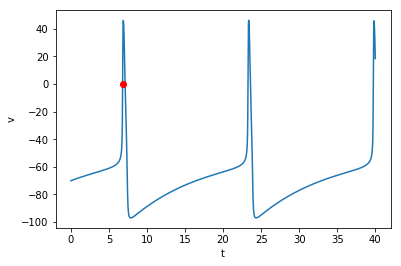

In [4]:
# ------------------------------------------------------------

if __name__=='__main__':
    # need the __main__ to use above functions as imports without running this part
    print('-------- Test: Hodgkin-Huxley system')
    par_args = {'gna': 100, 'gk': 80, 'gl': 0.1,
                'vna': 50, 'vk': -100, 'vl': -67,
                'Iapp': 1.75, 'C': 1.0}
    ic_args = {'v':-70.0, 'm': 0, 'h': 1, 'n': 0}

    # test single terminal event first
    print("Testing single terminal event and its sampling")

    thresh_ev = Events.makePythonStateZeroCrossEvent('v', 0, 1,
                                       {'name': 'thresh_ev',
                                        'eventtol': 1e-4,
                                        'precise': True,
                                        'term': False})

    thresh_ev_term = Events.makePythonStateZeroCrossEvent('v', 0, 1,
                                       {'name': 'thresh_ev',
                                        'eventdelay': 1e-4,
                                        'eventtol': 1e-4,
                                        'precise': True,
                                        'term': True})

    HH_term = makeHHneuron('HHtest', par_args, ic_args, [thresh_ev_term])
    HH_term.set(tdata=[0, 25])
    start = clock()
    HHtraj_term = HH_term.compute('test_term')
    print('Computed trajectory in %.3f seconds.\n' % (clock()-start))
    trajdata = HHtraj_term.sample(dt=1.0, precise=True)
    print("sampled this data up until the event", HH_term.getEventTimes(), ":")
    print(trajdata['v'], "\n")


    HH = makeHHneuron('HHtest', par_args, ic_args, [thresh_ev])

    # test user interface to auxiliary functions
    assert HH.auxfns.ptest(4) == 1+4+HH.auxfns.ma(-50)+par_args['C'], "Failure of user interface to auxiliary functions"
    HH.set(pars={'C':101})
    assert HH.auxfns.ptest(4) == 1+4+HH.auxfns.ma(-50)+101, "Failure of user interface to auxiliary functions"
    assert HH.auxfns.atest(2.4) == 2.4+HH.auxfns.mb(-40), "Failure of user interface to auxiliary functions"
    HH.set(pars={'C':par_args['C']})

    # HH is a "Generator" object (an ODE in this case)
    # (Generator is the new name for the DynamicalSystem class, because some
    # subclasses, for instance ones for trajectories given by explicit
    # equations, are not dynamical systems!)
    HH.set(tdata=[0, 6.797])

    print('Integrating...')
    start = clock()
    HHtraj = HH.compute('test')
    print('  ... finished in %.3f seconds.\n' % (clock()-start))
    evt = HH.getEventTimes()['thresh_ev']
    evt_same = HH.getEventTimes('thresh_ev')
    assert evt == [] == evt_same

    print('Saving Model and Trajectory...')
    saveObjects([HH, HHtraj], 'data/temp_HH.pkl', True)

    # try a longer run
    print("Trying a longer run")
    HH.set(tdata=[0, 40])
    HHtraj2 = HH.compute('test_long')
    evts=HH.getEvents()
    HH.set(tdata=[40, 60])
    HHtraj3 = HH.compute('test_long_c','c')
    print("In 50ms, found the following events:")
    evts_c=HH.getEvents()
    all_evts = copy(evts)
    for k, a in list(evts_c.items()):
        if k in evts and a is not None:
            all_evts[k].append(a)
        else:
            all_evts[k] = a
    print(all_evts)
    assert len(all_evts['thresh_ev']) == 4, "Problem with ODE events"
    assert allclose(all_evts['thresh_ev']['t'][3], 56.218, 1e-3), "Problem with ODE events"

    plotData = HHtraj2.sample()  # works but not VODE accurate for non-terminal events
    yaxislabelstr = 'v'
    plt.ylabel(yaxislabelstr)
    plt.xlabel('t')
    vline = plt.plot(plotData['t'], plotData['v'])
    # pick out first event
    evt = evts['thresh_ev']['t'][0]
    plt.plot(evt, HHtraj(evt, 'v'), 'ro')
   
    plt.show()

As we can see with the code, we do not only simulate a HHneuron. Indeed we are able to collect the events (like threshold) during the computation. Moreover we can save the model and data, and work with the trajectory as with any parametrized function. 

The next code is just here to explain how to lad a model already define and save.

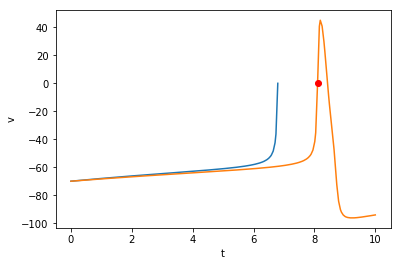

In [5]:
"""HH Re-load test. Only run after test 'HH_model.py'
"""


try:
    objs = loadObjects('data/temp_HH.pkl')
except:
    print("Only run after test 'HH_model.py'")
    raise
HH = objs[0]
HHtraj1 = objs[1]
plotData1 = HHtraj1.sample(dt=0.05)
evt1=HH.getEventTimes()['thresh_ev'] # HH was last used to compute HHtraj1 in HH_model.py
assert evt1 == []

# test user interface to auxiliary functions
C=HH.pars['C']
assert HH.auxfns.ptest(4) == 1+4+HH.auxfns.ma(-50)+C, "Failure of user interface to auxiliary functions"
HH.set(pars={'C':101})
assert HH.auxfns.ptest(4) == 1+4+HH.auxfns.ma(-50)+101, "Failure of user interface to auxiliary functions"
HH.set(pars={'C':C})

# other tests
HH.set(tdata=[0, 10], pars={'C': 1.2}) # test of new value of C
HHtraj2 = HH.compute('test2')
plotData2 = HHtraj2.sample(dt=0.05)
evt2=HH.getEventTimes()['thresh_ev']
assert len(evt2) > 0

yaxislabelstr = 'v'
plt.ylabel(yaxislabelstr)
plt.xlabel('t')

vline1=plot(plotData1['t'], plotData1['v'])
vline2=plot(plotData2['t'], plotData2['v'])

try:                          # Just some test to check if the loading of objects is successfull
    HHtraj1(evt1, 'v')
except ValueError:
    # OK
    pass
else:
    raise RuntimeError("calling trajectory with empty time sequence should have failed")
plot(evt2, HHtraj2(evt2, 'v'), 'ro')
show()


Now we will go further with some phase plane analysis of the model we just compute. We will just redefine the HH class in order to be able to track the several events.

In [6]:
"""A demonstration of a Hodgkin-Huxley model with phase plane tools.

   Robert Clewley, April 2009.
Some modifications to adapt this code to this notebook : Kevin Berlemont , March, 2017
"""

from PyDSTool import *
from PyDSTool.Toolbox.phaseplane import *
import time
from copy import copy
global plotter

# ------------------------------------------------------------


def makeHHneuron(name, dt, par_args, ic_args, evs=None, extra_terms='',
                 with_flow_event=True):
    # extra_terms must not introduce new variables!
    vfn_str = '(I'+extra_terms+'-ionic(v,m,h,n))/C'
    mfn_str = 'ma(v)*(1-m)-mb(v)*m'
    nfn_str = 'na(v)*(1-n)-nb(v)*n'
    hfn_str = 'ha(v)*(1-h)-hb(v)*h'
    aux_str = 'm*m*m*h'

    # Testing: ptest in RHS function to test Jacobian computation of ionic with embedded aux function
    # ptest has no numeric effect on the ionic function otherwise
    auxdict = {'ionic': (['vv', 'mm', 'hh', 'nn'],
                              'gna*mm*mm*mm*hh*ptest(0)*(vv-vna) + gk*nn*nn*nn*nn*(vv-vk) + gl*(vv-vl)'),
               'ma': (['v'], '0.32*(v+54)/(1-exp(-(v+54)/4.0))'),
               'mb': (['v'], '0.28*(v+27)/(exp((v+27)/5.0)-1)'),
               'ha': (['v'], '.128*exp(-(50+v)/18.0)'),
               'hb': (['v'], '4/(1+exp(-(v+27)/5.0))'),
               'na': (['v'], '.032*(v+52)/(1-exp(-(v+52)/5.0))'),
               'nb': (['v'], '.5*exp(-(57+v)/40.0)'),
               'ptest': (['p'], '-C+(1+p+C)*1')} # use model parameter in this function to test jacobian creation below

    DSargs = args()
    DSargs.varspecs = {'v': vfn_str, 'm': mfn_str,
                       'h': hfn_str, 'n': nfn_str,
                       'v_bd0': 'getbound("v",0)',
                       'v_bd1': 'getbound("v",1)'}
    DSargs.pars = par_args
    DSargs.auxvars = ['v_bd0','v_bd1']
    DSargs.fnspecs = auxdict
    DSargs.xdomain = {'v': [-130, 70], 'm': [0,1], 'h': [0,1], 'n': [0,1]}
    DSargs.algparams = {'init_step':dt, 'max_step': dt*1.5,
                        'max_pts': 300000, 'refine': 1}

    DSargs.checklevel = 0
    DSargs.ics = ic_args
    DSargs.name = name

    if with_flow_event:
        ev, ev_helper=make_flow_normal_event('v', 'm', vfn_str, mfn_str,
                          targetlang='c',
                          fnspec={'vars': ['v', 'm', 'h', 'n'],
                                  'pars': list(par_args.keys()),
                                  'inputs': [],
                                  'auxfns': auxdict},
                          evtArgs={'eventtol': 1e-8,
                                   'eventdelay': 1e-7,
                                   'starttime': 0,
                                   'term': False})
        for p in ev_helper['pars_to_vars']:
            if p in DSargs:
                raise ValueError("Parameter name %s already in system specification"%p)
            DSargs.pars[p] = 0
        if evs is None:
            evs = [ev]
        else:
            evs.append(ev)
    else:
        ev_helper = None

    if evs is not None:
        DSargs.events = evs
    return (Generator.Vode_ODEsystem(DSargs), ev_helper)

'Make_flow_normal_event' is a function from the Toolbox that detects when flow is perpendicular to a given vector in 2D.

Phase Plane test using Hodgkin-Huxley system during action potential
Finding analytic Jacobian w.r.t. phase-plane variables v, m...
Use of Jacobian speeds up finding of nullclines and fixed points by
nearly a factor of two (not including time to plot results)...


/home/kevin/miniconda3/envs/ipykernel_py2/lib/python2.7/site-packages/PyDSTool/Toolbox/phaseplane.py:1350: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x0 = array([x0_coords[i][d_posns[i]] for i in range(D)])


({'h': 0.7, 'v': -77.850773852867022, 'm': 0.0013808106543117778, 'n': 0.2}, {'h': 0.7, 'v': -57.535395656510929, 'm': 0.085055844998493613, 'n': 0.2}, {'h': 0.7, 'v': 49.584923213480046, 'm': 0.99999985586385576, 'n': 0.2})
Fixed points for (v,m) phase plane sub-system when h=0.70 and n=0.20: 
For classification and stability, we use the fixedpoint class...
F.p. at (-77.85077, 0.00138) is a node and has stability s
F.p. at (-57.53540, 0.08506) is a saddle and has stability u
F.p. at (49.58492, 1.00000) is a node and has stability s


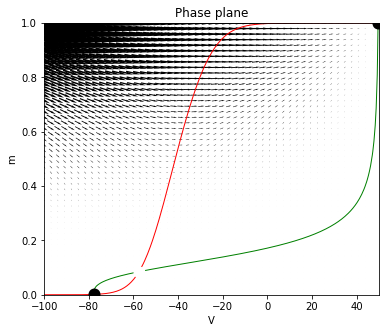

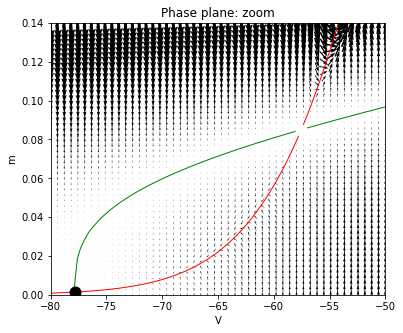

In [7]:

print('Phase Plane test using Hodgkin-Huxley system during action potential')
par_args = {'gna': 100, 'gk': 80, 'gl': 0.1,
            'vna': 50, 'vk': -100, 'vl': -67,
            'I': 1.75, 'C': 1.0}

# very close to a periodic orbit
ic_args = {'v_bd0': -130.0, 'v_bd1': 70.0, 'h': 0.99599864212873856,
           'm': 0.00050362509755992027, 'n': 0.00557358064026849,
           'v': -82.018860813828837}

HH, ev_helper = makeHHneuron('HH_PP_test', 0.1, par_args, ic_args)
HH.set(tdata=[0, 100], ics={'h':0.7, 'n': 0.2})

print("Finding analytic Jacobian w.r.t. phase-plane variables v, m...")
jac, new_fnspecs = prepJacobian(HH.funcspec._initargs['varspecs'], ['m', 'v'],
                                HH.funcspec._initargs['fnspecs'])

scope = copy(HH.pars)
scope.update({'n': HH.initialconditions['n'], 'h': HH.initialconditions['h']})
scope.update(new_fnspecs)
jac_fn = expr2fun(jac, ensure_args=['t'], **scope)

print("Use of Jacobian speeds up finding of nullclines and fixed points by")
print("nearly a factor of two (not including time to plot results)...")
fp_coords = find_fixedpoints(HH, n=4, jac=jac_fn, eps=1e-8,
                             subdomain={'v':HH.xdomain['v'],'m':HH.xdomain['m'],
                             'h': HH.initialconditions['h'], 'n': HH.initialconditions['n']})
nulls_x, nulls_y = find_nullclines(HH, 'v', 'm', n=3, jac=jac_fn, eps=1e-8, max_step=0.5,
                             subdomain={'v':HH.xdomain['v'],'m':HH.xdomain['m'],
                             'h': HH.initialconditions['h'], 'n': HH.initialconditions['n']},
                             fps=fp_coords)

N_x = nullcline('v', 'm', nulls_x)
N_y = nullcline('v', 'm', nulls_y)

print (fp_coords)
print("Fixed points for (v,m) phase plane sub-system when h=%.2f and n=%.2f: " % (HH.initialconditions['h'], HH.initialconditions['n']))
print("For classification and stability, we use the fixedpoint class...")

fps=[]
for i in range(len(fp_coords)):
    fps.append(fixedpoint_2D(HH, Point(fp_coords[i]), coords=['v', 'm'],
                         jac=jac_fn, description=i, eps=1e-8))


for fp in fps:
    print("F.p. at (%.5f, %.5f) is a %s and has stability %s" % (fp.point['v'],
                            fp.point['m'], fp.classification, fp.stability))

plotter.fig_directory = {'PP_large': 1,
                         'PP_small': 2}
plotter.do_display=True
plotter.set_curr_fig('PP_large')
plotter.plot_nullcline(N_x, 'g')
plotter.plot_nullcline(N_y, 'r')
plotter.plot_fps(fps, 'v', 'm')
# scale_exp needs to be adjusted to get arrow sizes right for scale of vector field
plotter.plot_vf(HH, 'v', 'm', subdomain={'v': [-100, 50]}, scale_exp=1, N=50)
plt.xlabel('V')
plt.ylabel('m')
plt.title('Phase plane')

plotter.set_curr_fig('PP_small')
plotter.xdom = [-80, -50]
plotter.plot_nullcline(N_x, 'g')
plotter.plot_nullcline(N_y, 'r', N=200)
plotter.plot_fps(fps, 'v', 'm')
plotter.plot_vf(HH, 'v', 'm', subdomain={'v': [-80, -50], 'm': [0,0.14]}, scale_exp=0.2, N=50)
plt.xlabel('V')
plt.ylabel('m')
plt.title('Phase plane: zoom')
plt.show()


NB : we do not find the unstable fixed point at the boundary. Need to improve it.

### Another model : Fitzugh-Nagumo Model

For this model the equations are as follow :

$$ \dot v = v - \frac{v^3}{3} -w + I$$
$$ \dot w = \epsilon(v + a - b w)$$
We are going to solve in the same way as before, but we will introduce some new features that are self understanding with the explained code.

In [10]:
def makeFHNneuron(name, dt, par_args, ic_args, evs=None,
                 with_flow_event=True):
    
    ufn_str = 'I+u - (u*u*u)/3-w'
    wfn_str = 'eps*(b0+u - b1*w)'
    
    # Testing: ptest in RHS function to test Jacobian computation of ionic with embedded aux function
    # ptest has no numeric effect on the ionic function otherwise
    
    DSargs = args()
    DSargs.varspecs = {'u': ufn_str, 'w': wfn_str,
                       'u_bd0': 'getbound("u",0)',
                       'u_bd1': 'getbound("u",1)'}
    DSargs.pars = par_args
    DSargs.auxvars = ['u_bd0','u_bd1']
    
    DSargs.xdomain = {'u': [-3, 3], 'w': [-3,3]}
    DSargs.algparams = {'init_step':dt, 'max_step': dt*1.5,
                        'max_pts': 300000, 'refine': 1}

    DSargs.checklevel = 0
    DSargs.tdata=[0,30]   # time in order to simulate the trajectory
    DSargs.ics = ic_args
    DSargs.name = name

    if with_flow_event:
        ev, ev_helper=make_flow_normal_event('u', 'w', ufn_str, wfn_str,
                          targetlang='c',
                          fnspec={'vars': ['u', 'w'],
                                  'pars': list(par_args.keys()),
                                  'inputs': []},
                          evtArgs={'eventtol': 1e-8,
                                   'eventdelay': 1e-7,
                                   'starttime': 0,
                                   'term': False})
        for p in ev_helper['pars_to_vars']:
            if p in DSargs:
                raise ValueError("Parameter name %s already in system specification"%p)
            DSargs.pars[p] = 0
        if evs is None:
            evs = [ev]
        else:
            evs.append(ev)
    else:
        ev_helper = None

    if evs is not None:
        DSargs.events = evs
    return (Generator.Vode_ODEsystem(DSargs), ev_helper)

In [11]:
print('Phase Plane test using FHN system during action potential')
par_args = {'b0': 0.7, 'b1': 0.8, 'eps': 0.08,
            'I': 1.0}

#close to a periodic orbit
ic_args = {'u_bd0': -3.0, 'u_bd1': 3.0, 'u': -2.0,
           'w': -0.5}

FHN, ev_helper = makeFHNneuron('FHN_PP_test', 0.1, par_args, ic_args)


print("Finding analytic Jacobian w.r.t. phase-plane variables v, m...")
jac, new_fnspecs = prepJacobian(FHN.funcspec._initargs['varspecs'], ['w', 'u'])

scope = copy(FHN.pars)
jac_fn = expr2fun(jac, ensure_args=['t'], **scope)

print("Use of Jacobian speeds up finding of nullclines and fixed points by")
print("nearly a factor of two (not including time to plot results)...")
fp_coords = find_fixedpoints(FHN, n=4, jac=jac_fn, eps=1e-8,
                             subdomain={'u':FHN.xdomain['u'],'w':FHN.xdomain['w']})
nulls_x, nulls_y = find_nullclines(FHN, 'u', 'w', n=3, jac=jac_fn, eps=1e-8, max_step=0.5,
                             subdomain={'u':FHN.xdomain['u'],'w':FHN.xdomain['w']},
                             fps=fp_coords)

N_x = nullcline('u', 'w', nulls_x)
N_y = nullcline('u', 'w', nulls_y)

print (fp_coords)
print("For classification and stability, we use the fixedpoint class...")

fps=[]
for i in range(len(fp_coords)):
    fps.append(fixedpoint_2D(FHN, Point(fp_coords[i]), coords=['u', 'w'],
                         jac=jac_fn, description=i, eps=1e-8))


for fp in fps:
    print("F.p. at (%.5f, %.5f) is a %s and has stability %s" % (fp.point['u'],
                            fp.point['w'], fp.classification, fp.stability))
    
traj = FHN.compute('test_traj')
pts = traj.sample()


Phase Plane test using FHN system during action potential
Finding analytic Jacobian w.r.t. phase-plane variables v, m...
Use of Jacobian speeds up finding of nullclines and fixed points by
nearly a factor of two (not including time to plot results)...
({'u': 0.40886583694341178, 'w': 1.3860822961792647},)
For classification and stability, we use the fixedpoint class...
F.p. at (0.40887, 1.38608) is a node and has stability u


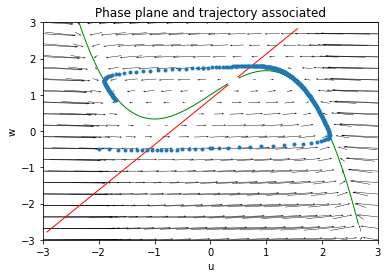

In [12]:
plt.clf()
plotter.fig_directory = {'PP_large': 1,
                         'PP_small': 2}
plotter.do_display=True
plotter.set_curr_fig('PP_large')
plotter.plot_nullcline(N_x, 'g')
plotter.plot_nullcline(N_y, 'r')
plotter.plot_fps(fps, 'u', 'w')
# scale_exp needs to be adjusted to get arrow sizes right for scale of vector field
plotter.plot_vf(FHN, 'u', 'w', subdomain={'v': [-3, 3]}, scale_exp=0.1, N=20)
plt.plot(pts['u'], pts['w'], '.', linewidth=1)
plt.xlabel('u')
plt.ylabel('w')
plt.title('Phase plane and trajectory associated')
plt.show()

Here we can observe that depending on the value of $I$ the fixed point will be stable or unstable. To highlight this fact we can compute the bifurcation diagram. When unstable we observe a limit cycle as trajectory.

Checking...
  |q| = 1.000000
  |<p,q> - 1| =  2.2215737401e-16
  |Aq - iwq| = 0.000000
  |A*p + iwp| = 0.000000

H Point found 
0 : 
I  =  0.33128133451
u  =  -0.967470932279
w  =  -0.334338665349

Eigenvalues = 

     (-0.000000,0.275507)
     (-0.000000,-0.275507)


w = 0.27550680628255947
l1 = 0.2677846914760722

Checking...
  |q| = 1.000000
  |<p,q> - 1| =  6.80019972136e-18
  |Aq - iwq| = 0.000000
  |A*p + iwp| = 0.000000

H Point found 
0 : 
I  =  1.41871870177
u  =  0.96747096287
w  =  2.08433870359

Eigenvalues = 

     (-0.000000,0.275507)
     (-0.000000,-0.275507)


w = 0.27550681319444598
l1 = 0.26778521535460492

B Point found 
0 : 
I  =  2.93766667507
u  =  1.70000000268
w  =  3.00000000334

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "_auto_FHN_PP_test_

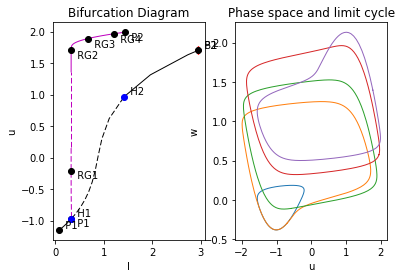

In [13]:
# Prepare the system to start close to a steady state
FHN.set(pars = {'I': 0} )       # Lower bound of the control parameter 'i'
FHN.set(ics =  {'u': -1.1} )       # Close to one of the steady states present for i=0

PC = ContClass(FHN)            # Set up continuation class

PCargs = args(name='EQ1', type='EP-C')     # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['I']                    # control parameter(s) (it should be among those specified in DSargs.pars)
PCargs.MaxNumPoints = 150                      # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 2
PCargs.MinStepSize  = 1e-5
PCargs.StepSize     = 2e-2
PCargs.LocBifPoints = 'all'    # detect limit points / saddle-node bifurcations
PCargs.StopAtPoints= 'B' # stop at boundary
PCargs.SaveJacobian=True
PCargs.verbosity = 2
PCargs.SaveEigen    = True                     # to tell unstable from stable branches

PC.newCurve(PCargs)
PC['EQ1'].forward() 

PCargs.name = 'LC1'
PCargs.type = 'LC-C'
PCargs.initpoint = 'EQ1:H1'
PCargs.MinStepSize = 0.005
PCargs.MaxStepSize = 0.5
PCargs.StepSize = 0.01
PCargs.MaxNumPoints = 150
PCargs.LocBifPoints = []
PCargs.NumSPOut = 30;
PCargs.SolutionMeasures = 'all'
PCargs.SaveEigen = True
PC.newCurve(PCargs)
print ('Computing curve...')

PC['LC1'].forward()
PC['LC1'].display(('I','u'), stability=True,axes=(1,2,1))




PC['EQ1'].display(['I','u'], stability=True)        # stable and unstable branches as solid and dashed curves, resp.
PC['LC1'].plot_cycles(coords=('u','w'),linewidth=1, axes=(1,2,2))
PC.plot.fig1.axes1.axes.set_title('Bifurcation Diagram')
PC.plot.fig1.axes2.axes.set_title('Phase space and limit cycle')
plt.show()